In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from cauchy_simulations import CauchyLiquidityProfile, NormalLiquidityProfile, from_bps_tick

In [94]:
C = 10.0  # total liquidity parameter
GAMMA = 0.1  # scale parameter
SIGMA = GAMMA * np.sqrt(2)  # scale parameter (mul by sqrt(2) to match stable distr parametrizations)
MAX_TICK = 887272
TICK_SPACING = 10  # step size between ticks in arrays

In [95]:
clp = CauchyLiquidityProfile(c=C, gamma=GAMMA)

In [96]:
nlp = NormalLiquidityProfile(c=C, sigma=SIGMA)

In [97]:
bps_ticks = np.arange(start=-MAX_TICK, stop=MAX_TICK, step=TICK_SPACING)

In [98]:
df = pd.DataFrame(data={'bps_ticks': bps_ticks, 'log_ticks': from_bps_tick(bps_ticks)})

In [99]:
# plot liquidity profile over ticks
df[f'cl(t) [c={clp.c}, g={clp.gamma}]'] = clp.at(df['log_ticks'])
df[f'nl(t) [c={nlp.c}, s={nlp.sigma}]'] = nlp.at(df['log_ticks'])

In [100]:
df

,bps_ticks,log_ticks,"cl(t) [c=10.0, g=0.1]","nl(t) [c=10.0, s=0.14142135623730953]"
0,-887272,-88.722764,0.00004,0.0
1,-887262,-88.721764,0.00004,0.0
2,-887252,-88.720764,0.00004,0.0
3,-887242,-88.719764,0.00004,0.0
4,-887232,-88.718764,0.00004,0.0
...,...,...,...,...
177450,887228,88.718364,0.00004,0.0
177451,887238,88.719364,0.00004,0.0
177452,887248,88.720364,0.00004,0.0
177453,887258,88.721364,0.00004,0.0


<Axes: xlabel='bps_ticks'>

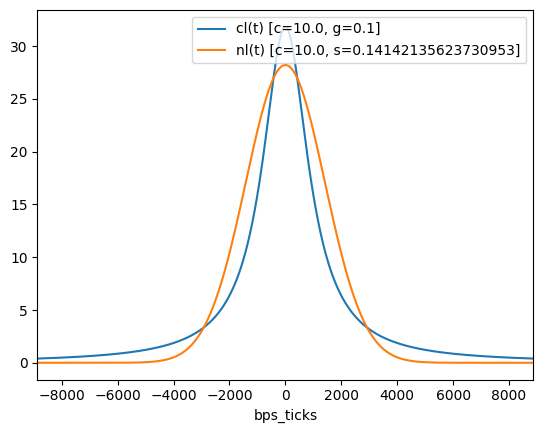

In [101]:
df.plot(x='bps_ticks', y=[f'cl(t) [c={clp.c}, g={clp.gamma}]', f'nl(t) [c={nlp.c}, s={nlp.sigma}]'], xlim=(-MAX_TICK // 100, MAX_TICK // 100))

In [104]:
# generate for more gammas
gammas = np.array([0.0125, 0.025, 0.05, 0.1, 0.2, 0.5, 1.0])

In [105]:
def to_sigma(g: float) -> float:
    return np.sqrt(2) * g

In [106]:
np.isclose(to_sigma(GAMMA), SIGMA)

True

In [107]:
sigmas = to_sigma(gammas)

In [108]:
sigmas

array([0.01767767, 0.03535534, 0.07071068, 0.14142136, 0.28284271,
       0.70710678, 1.41421356])

In [109]:
# try for various sigmas
for s in sigmas:
    df[f'nl(t) [c={C}, s={s}]'] = NormalLiquidityProfile(c=C, sigma=s).at(df['log_ticks'])

<Axes: xlabel='bps_ticks'>

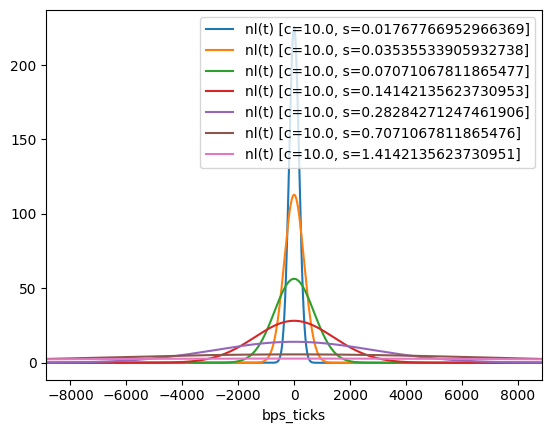

In [111]:
# plot across sigmas
df.plot(x='bps_ticks', y=[f'nl(t) [c={C}, s={s}]' for s in sigmas], xlim=(-MAX_TICK // 100, MAX_TICK // 100))

In [112]:
# to compare with curve, calculate the amount of x out required to move pool to tick t for various ticks
top = 40000 # bps
width = TICK_SPACING
bps_ticks_in_ranges = np.array([width * i for i in range((top + width) // width)])
df_w_ranges = pd.DataFrame(data={
    'bps_ticks': bps_ticks_in_ranges,
    'log_ticks': from_bps_tick(bps_ticks_in_ranges),
    'price': np.exp(from_bps_tick(bps_ticks_in_ranges)),
    'price^{-1}': np.exp(-from_bps_tick(bps_ticks_in_ranges))
})

In [113]:
%%capture
# calculate relevant curve slippage quantities for different sigma values
for s in sigmas:
    print(f"Calculating in/out slippage quantities for sigma: {s} ...", end='\r')

    # xout, yin and initial reserves
    df_w_ranges[f'xout [c={C}, s={s}]'] = df_w_ranges['bps_ticks'].apply(lambda t: NormalLiquidityProfile(c=C, sigma=s).cost_x(from_bps_tick(0), from_bps_tick(t)))
    df_w_ranges[f'yin [c={C}, s={s}]'] = df_w_ranges['bps_ticks'].apply(lambda t: NormalLiquidityProfile(c=C, sigma=s).cost_y(from_bps_tick(0), from_bps_tick(t)))
    df_w_ranges[f'rx0 [c={C}, s={s}]'] = df_w_ranges['bps_ticks'].apply(lambda t: NormalLiquidityProfile(c=C, sigma=s).reserves_x(from_bps_tick(0), from_bps_tick(MAX_TICK)))
    df_w_ranges[f'ry0 [c={C}, s={s}]'] = df_w_ranges['bps_ticks'].apply(lambda t: NormalLiquidityProfile(c=C, sigma=s).reserves_y(from_bps_tick(0), from_bps_tick(MAX_TICK)))

    # ratios for plotting
    df_w_ranges[f'xout/rx0 [c={C}, s={s}]'] = df_w_ranges[f'xout [c={C}, s={s}]'] / df_w_ranges[f'rx0 [c={C}, s={s}]']
    df_w_ranges[f'|xout|/rx0 [c={C}, s={s}]'] = np.abs(df_w_ranges[f'xout [c={C}, s={s}]']) / df_w_ranges[f'rx0 [c={C}, s={s}]']
    df_w_ranges[f'yin/ry0 [c={C}, s={s}]'] = df_w_ranges[f'yin [c={C}, s={s}]'] / df_w_ranges[f'ry0 [c={C}, s={s}]']

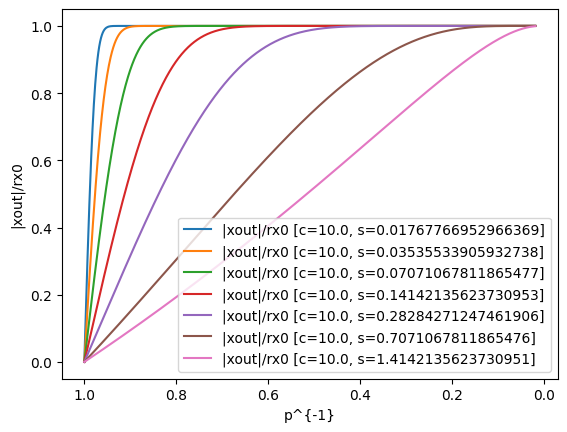

In [116]:
ax = df_w_ranges.plot(x='price^{-1}', y=[f'|xout|/rx0 [c={C}, s={s}]' for s in sigmas], xlabel='p^{-1}', ylabel=f'|xout|/rx0', label=[f'|xout|/rx0 [c={C}, s={s}]' for s in sigmas])
ax.invert_xaxis()

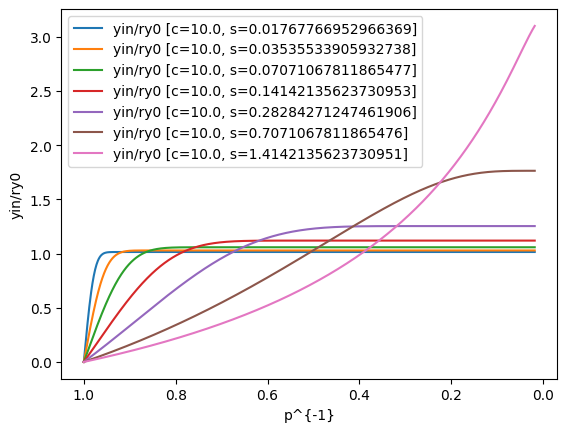

In [117]:
ax = df_w_ranges.plot(x='price^{-1}', y=[f'yin/ry0 [c={C}, s={s}]' for s in sigmas], xlabel='p^{-1}', ylabel=f'yin/ry0', label=[f'yin/ry0 [c={C}, s={s}]' for s in sigmas])
ax.invert_xaxis()

In [ ]:
# wider gaussian with less tails doesnt really help that much
# seems smoother and closer to constant sum using cauchy, then should modify with full range constant liquidity base (modified)